# NAC-free NA-MD calculations with Belyaev-Lebedev-Landau-Zener (BLLZ) method


## Table of Content: <a name="TOC"></a>

1. [Generic setups](#1)

2. [Theoretical Background](#2)

3. [Calculations](#3)

4. [Visualization](#4)


## A. Learning objectives

- to be able to setup the NBRA NA-MD calculations for the BLLZ method
- to know what properties can be computed with this method
- to be able to visualize some key properties from the BLLZ NBRA calculations


## B. Use cases

- Read the vibronic Hamiltonian data files to obtain its properties


## C. Functions

- `libra_py`
  - `data_conv`
    - [`MATRIX2nparray`](#MATRIX2nparray-1)
  - `workflows`
    - `nbra`
      - `lz`
        - [`run`](#run-1)
      - `step4`
        - [`get_Hvib2`](#get_Hvib2-1)


## D. Classes and class members
    


## 1. Generic setups
<a name="1"></a>[Back to TOC](#TOC)

Here, we import all necessary libraries. In particular, note the `libra_py.workflows.nbra.lz` library - it is the one that contains the main workflow for the BLLZ calculation

In [2]:
import os
import sys

from liblibra_core import *
import util.libutil as comn
from libra_py import units
from libra_py.workflows.nbra import lz, step4
from libra_py import data_outs, data_conv

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
%matplotlib inline

## 2. Theoretical background
<a name="2"></a>[Back to TOC](#TOC)

The calculations are based on the pioneering method of Belyaev and Lebedev ([A.K. Belyaev, and O.V. Lebedev, “Nonadiabatic nuclear dynamics of atomic collisions based on branching classical trajectories,” Phys. Rev. A 84(1), 014701 (2011)](10.1103/PhysRevA.84.014701) ) who reformulated the famous Landau-Zener nonadiabatic transition probability (L. D. Landau, Phys. Z. Sowjetunion 1, 88 (1932); 2, 46 (1932); C. Zener, Proc. R. Soc. London, Ser. A 137, 696 (1932) ) formula in terms of only adiabatic properties, in particular the adiabatic energy gaps and their time-derivatives. As such, no information on nonadiabatic couplings (NAC) or derivative coupling vectors usually used in NA-MD calculations is needed.

The original formula for Landau and Zener for probability of state transition between adiabatic states in a 2-level system is given by:

$P_{ij}^{LZ} = exp(-\frac{ 2 \pi H_{ij}^2 } { \hbar | \nabla_R H_{ii} - \nabla_R H_{jj}| v } )$ 

where $v$ are the nuclear velocities, $H_{ij}$ are the diabatic couplings and $\nabla H_{ii}$ is the gradient of the diabatic energies with respect to nuclear coordinates. 

In particular, if two diabatic states are decoupled $H{ij} = 0$, the state transition probability is 1, meaning there is a certain switch between adiabatic states, needed for system to stay on the original diabatic surface. Vice versa, if the coupling is very large, the transition probability between adiabatic states is nearly zero, so one essentially switches between diabatic surfaces.

The reformulation of LZ method by Belyaev and Lebedev yields:

$P_{ij}^{BL} = exp(-\frac{\pi}{2 \hbar} \sqrt {  \frac{Z_{ij}^3}{ {\partial^2 Z_{ij} } / {\partial t^2} } } )$

where $Z_{ij}$ is the absolute value of the adiabatic energy gap, $Z_{ij} = |E_i - E_j|$

The formula is applied at the points where the energy gap is at local minimum. 

The approach has been first extended to complex atomistic systems in [B. Smith, and A.V. Akimov, “Hot Electron Cooling in Silicon Nanoclusters via Landau–Zener Nonadiabatic Molecular Dynamics: Size Dependence and Role of Surface Termination,” J. Phys. Chem. Lett. 11(4), 1456–1465 (2020)](https://doi.org/10.1021/acs.jpclett.9b03687).

First, the hopping probability $P_{ij}^{BL}$ is considered a hop proposal brobability, $P_{ij}^{BL} ->P_{ij, proposal}^{BL}$ To account for potential frustrated hops,  one needs to scale the overal transition probabilities by the hop acceptance probabilities taken as Boltzman probabilities:

$P_{ij,acc} = min(1, exp(-\frac{Z_{ij}}{k_B T } )$

The overall hopping probability is then:

$P_{ij}^{BLLZ} = P_{ij,proposal}^{BL} P_{ij, acc}$

However, with multiple closely-spaced energy levels, the hopping probabilities $P_{ij}^{BLLZ}$ may add up to more than 1. Thus, the probabilities are renormalized, as described in the above paper:

$P_{ij}^{BLLZ} -> P_{ij}^{BLLZ}= \frac{P_{ij}^{BLLZ} }{\sum_{k\neq i} P_{ik}^{BLLZ}}$

The resulting hopping probabilities are used to solve a master equation:

$p(t+dt) = P^{BLLZ}(t,t+dt) p(t)$

where $p(t)$ is the population vector and $P^{BLLZ}$ is the transition matrix computed as described above. 

The above workflow is implemented in Libra package within the `libra_py.workflows.nbra.lz` package.

>
> WARNING: The BLLZ approach is not applicable when the energy gap is very large, especially
> if there are many states involved
>


## 3. Calculations
<a name="3"></a>[Back to TOC](#TOC)

To get the calculations going, we first need to load the files. First, let's unpack the provided archive with the data provided:

In [2]:
! tar -xjf SD_basis_1.tar.bz2

Next, we can read in all the files usin `step4.get_Hvib2` function:

Some key parameters:

* `data_set_paths` - the list of path prefixes from which to read the files
* `Hvib_re_prefix` and `Hvib_re_suffix` - prefix and suffix of the files to read, real parts
* `Hvib_im_prefix` and `Hvib_im_suffix` - prefix and suffix of the files to read, imaginary parts
* `init_time` - the initial index of the files to read
* `nfiles` - how many files to read
* `nstates` - how many states is contained in the files
* `active_space` - what subset of states to read
<a name="get_Hvib-1"></a>

In [3]:
params = { "data_set_paths": ["SD_basis_1/"], 
           "Hvib_re_prefix": "Hvib_sd_", "Hvib_re_suffix" : "_re", 
           "Hvib_im_prefix": "Hvib_sd_", "Hvib_im_suffix" : "_im",
           "init_times":1,  "nfiles":1000, 
           "nstates":37,"active_space": list(range(37) )
         }

#====== Use this function for text files
# Hvibs = step4.get_Hvib2(params)
#====== Use this function for npz files
Hvibs = step4.get_Hvib_scipy(params)

In [4]:
help(step4.get_Hvib2)

Help on function get_Hvib2 in module libra_py.workflows.nbra.step4:

get_Hvib2(params)
    Reads several sets of vibronic Hamiltonian files 
    
    Args:
        params ( dictionary ): parameters controlling the function execution [Required!]
    
            Required parameter keys:
    
            * **params["data_set_paths"]** ( list of strings ):
                define the paths of the directories where the vibronic Hamiltonian files for
                different data sets (e.g. independent MD trajectories) are located. 
            .. note::
                In addition, requires parameters described in
                :func:`libra_py.workflows.nbra.step4.getHvib`
    
    Returns:
        list of lists of CMATRIX: Hvib: 
            the time series of Hvib matrices for several data sets, such that
            Hvib[idata][time] is a CMATRIX for the data set indexed by `idata`
            at time `time`
    
    Example:
        The full name of the vibronic Hamiltonian files rea

In [10]:
help(step4.get_Hvib_scipy)

Help on function get_Hvib_scipy in module libra_py.workflows.nbra.step4:

get_Hvib_scipy(params)
    This function is used to get the set of Hvibs (or any other set of data like 
    St matrices) in scipy.sparse format and return them as CMATRIX format.
    Args:
        params (dictionary): parameters controlling the function execution [Required!]
    
            Required parameter keys:
    
            * **params["data_set_paths"]** ( list of strings ):
                define the paths of the directories where the vibronic Hamiltonian files for
                different data sets (e.g. independent MD trajectories) are located. 
            .. note::
                In addition, requires parameters described in
                :func:`libra_py.workflows.nbra.step4.getHvib`
    
    Returns:
        list of lists of CMATRIX: Hvib: 
            the time series of Hvib matrices for several data sets, such that
            Hvib[idata][time] is a CMATRIX for the data set indexed by `idata

Once we have a list of vibronic Hamiltonian files (out of which we only use the diagonal elements only - energies of adiabatic states), we can start the calculations, using the function `lz.run`. Some key parameters:

* `ntraj = 1` - since the NBRA formulation of the BLLZ approach is a master-equation, we only need 1 trajectory
* `nsteps` - how many steps to take
* `istate` - the initial state from which to start calculations
<a name="run-1"></a>

In [4]:
params = { "dt":0.5*units.fs2au, "ntraj":1, "nsteps":1000, "istate":30, 
           "Boltz_opt_BL":1, "Boltz_opt":1, "T":300.0,  
           "do_output":True, "outfile":"BL.txt", "do_return":True, 
           "evolve_Markov":True, "evolve_TSH":False, 
           "extend_md":False, "extend_md_time":1000,
           "detect_SD_difference":False,   "return_probabilities":False,
           "init_times":[0]           
         }
params["gap_min_exception"] = 0 # what to do if the extrapolated gap is negative: 0 - set to zero, 1 - use the mid-point gap
params["target_space"] = 0 # how to select the space of target states for each source state: 0 - only adjacent states, 1 - all states


res, _ = lz.run(Hvibs, params)

The resuls are summarized in the object `res` which has the following format:

    MATRIX(1, 3*nstates+4): the trajectory (and initial-condition)-averaged observables,
            the assumed format is:

    First state info        ...          N-st state info All-states-related data

    E(0), P_SE(0), P_SH(0), ...,   E(nst-1), P_SE(nst-1), P_SH(nst-1), <E*P_SE>, <E*P_SH>, sum{P_SE}, sum{P_SH}
    
    
More on the function can be found here:

In [6]:
help(lz.run)

Help on function run in module libra_py.workflows.nbra.lz:

run(H_vib, params)
    Main function to run the SH calculations based on the Landau-Zener hopping
    probabilities, all within the NBRA. The probabilities are implemented according to
    the Belyaev-Lebedev work.
    
    Args:
        params ( dictionary ): control parameters
    
        * **params["dt"]** ( double ) : time distance between the adjacent data points [ units: a.u.; default: 41.0 a.u.]
        * **params["ntraj"]** ( int ) : how many stochastic trajectories to use in the ensemble [ defult: 1]
        * **params["nsteps"]** ( int ) : how nuclear steps in the trajectory to be computed [ defult: 1]
        * **params["istate"]** ( int ) : index of the starting state (within those used in the active_space) [ default: 0]
        * **params["Boltz_opt_BL"]** ( int ) : what type of hop acceptance scheme to incorporate into the BL probabilities 
            Options:
    
            - 0 - all proposed hops are accept

It is also convenient to convert the result from the MATRIX type to the numpy array type by:
<a name="MATRIX2nparray-1"></a>

In [5]:
res0 = data_conv.MATRIX2nparray(res, _dtype=float)

In [8]:
help(data_conv.MATRIX2nparray)

Help on function MATRIX2nparray in module libra_py.data_conv:

MATRIX2nparray(data, _dtype=<class 'numpy.complex128'>)
    Converts both Libra MATRIX ( N, M ) object and CMATRIX ( N, M ) object 
    into a 2D np.array of shape( N, M )
    
    Args:
        data ( Libra MATRIX object of dimension N x M ): data to be converted
    Returns:
        2d np.array: 2D np.array of shape( N, M )



## 4. Visualization
<a name="4"></a>[Back to TOC](#TOC)

Using the knowledge on the expected format of the output, we can plot some properties.

First, we plot the average energies based on SE populations and SH populations. However, although the SH populations are present in the output, there are no actual hops, so the SH population of the initial energy level is 1 and doesn't change. Hence, the corresponding SH energy can be regarded as the evolution of the initial energy level (blue in the plot below).

On the contrary, the SE populations are propagated according to the master equation above, so the population of the initial state (30 in this example) decays and the lower-energy states get populated. As a result, the SE-population averaged energy shows decay, as expected. 

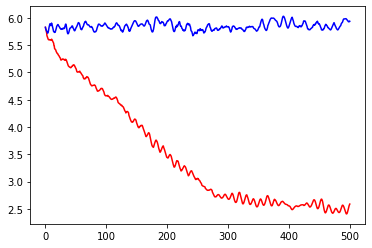

In [6]:
plt.plot(res0[:, 0]*units.au2fs, res0[:, 112]*units.au2ev, color="red", label="E_SE")
plt.plot(res0[:, 0]*units.au2fs, res0[:, 113]*units.au2ev, color="blue", label="E_SH")

One can also visuaize the energy levels in the data used:

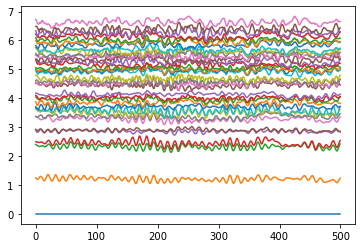

In [7]:
# Energies
for i in range(37):
    plt.plot(res0[:, 0]*units.au2fs, res0[:, 3*i+1]*units.au2ev)

Or the SE populations of individual states:

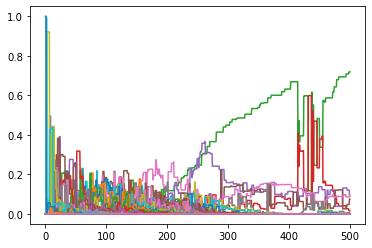

In [8]:
# SE populations
for i in range(37):
    plt.plot(res0[:, 0]*units.au2fs, res0[:, 3*i+2])

As mentioned before, the SH population of the initial state stays 1, so there is not much exciting to see here:

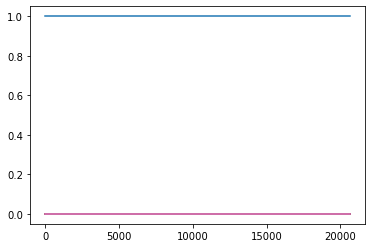

In [9]:
# SH populations
for i in range(37):
    plt.plot(res0[:, 0], res0[:, 3*i+3])